# fft score cam implementation


### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import wandb
import pickle
#from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import transform
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import cv2
from plotting_utils import RF_Visualizer
import pandas as pd
from scipy.fft import fft, ifft,fftshift
import os
import math
from scipy import signal

cur_dir = os.getcwd()
print(cur_dir)



/home/sagetrudeau/Projects/XAI/RF-Models-CAM-Evaluation


### Load Data

In [2]:
if __name__ == "__main__":
    from model import Baseline_CNN1D
    from dataset_tprime import TPrimeDataset
    import argparse
    from scipy.io import loadmat


    # seqs = {}
    # with open("/home/sagetrudeau/Datasets/ORACLE/mat_files/raw/train.pkl", "rb") as f:#Oracle
    # #with open("/raid/backup_storage_oldDGX/LORA/Year_1_outdoor/outdoor_dataset_1/mat_files/raw/train.pkl", "rb") as f:
    #     file_dict = pickle.load(f)
    # filenames = file_dict["files"]
    # print(filenames)
    # for i, name in enumerate(filenames):
    #     #print(i, len(filenames))
    #     seqs[name] = loadmat(name)["f_sig"][0]
    # #dataset = InDistributionTestDataset(seqs,"val")
    # dataset = InDistributionTestDatasetContinuous(seqs, "val")
    # #dataset = InDistributionTrainDataset(seqs)
    # train_dataset = InDistributionTrainDataset(seqs)
    # del seqs
    args=argparse.Namespace()
    args.protocols = ['802_11ax', '802_11b_upsampled', '802_11n', '802_11g']
    args.noise = True
    args.snr_db = [30]
    args.raw_path = "/home/sagetrudeau/Projects/t-prime/data/DATASET1_1"
    args.slicelen = 512
    args.overlap_ratio = 0.0
    args.postfix = ''
    args.raw_data_ratio = 1.0
    args.channel = None
    args.out_mode = 'real'
    args.worker_batch_size = 512

    ds_test = TPrimeDataset(args.protocols,
                          ds_path=args.raw_path,
                          ds_type='test',
                          snr_dbs=args.snr_db,
                          slice_len=args.slicelen,
                          slice_overlap_ratio=float(args.overlap_ratio),
                          raw_data_ratio=args.raw_data_ratio,
                          file_postfix=args.postfix,
                          override_gen_map=False,    # it will use the same as above call
                          apply_wchannel=args.channel,
                          apply_noise=args.noise,
                          out_mode=args.out_mode)
    dataloader = DataLoader(ds_test, batch_size=args.worker_batch_size, shuffle=False)


### Load model


In [3]:

#t-prime
PATH = './results/t-prime/SNR30/'
Nclass = 4
num_channels = 2
num_feats = 1
slice_len = 512
model = Baseline_CNN1D(classes=Nclass, numChannels=num_channels, slice_len=slice_len)
checkpoint = torch.load(cur_dir+"/model/model.baseline_cnn1d.nochan.30.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(model.device.type) # reload the model on the appropriate device
model.eval()    # set the evaluation mode
print(model)




Baseline_CNN1D(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(1,))
  (relu1): ReLU()
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16000, out_features=256, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)


### Experimenting with TSNE

(3584, 16000) (3584,)


/home/sagetrudeau/Projects/XAI/xai_venv/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [17:44:38.268856] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


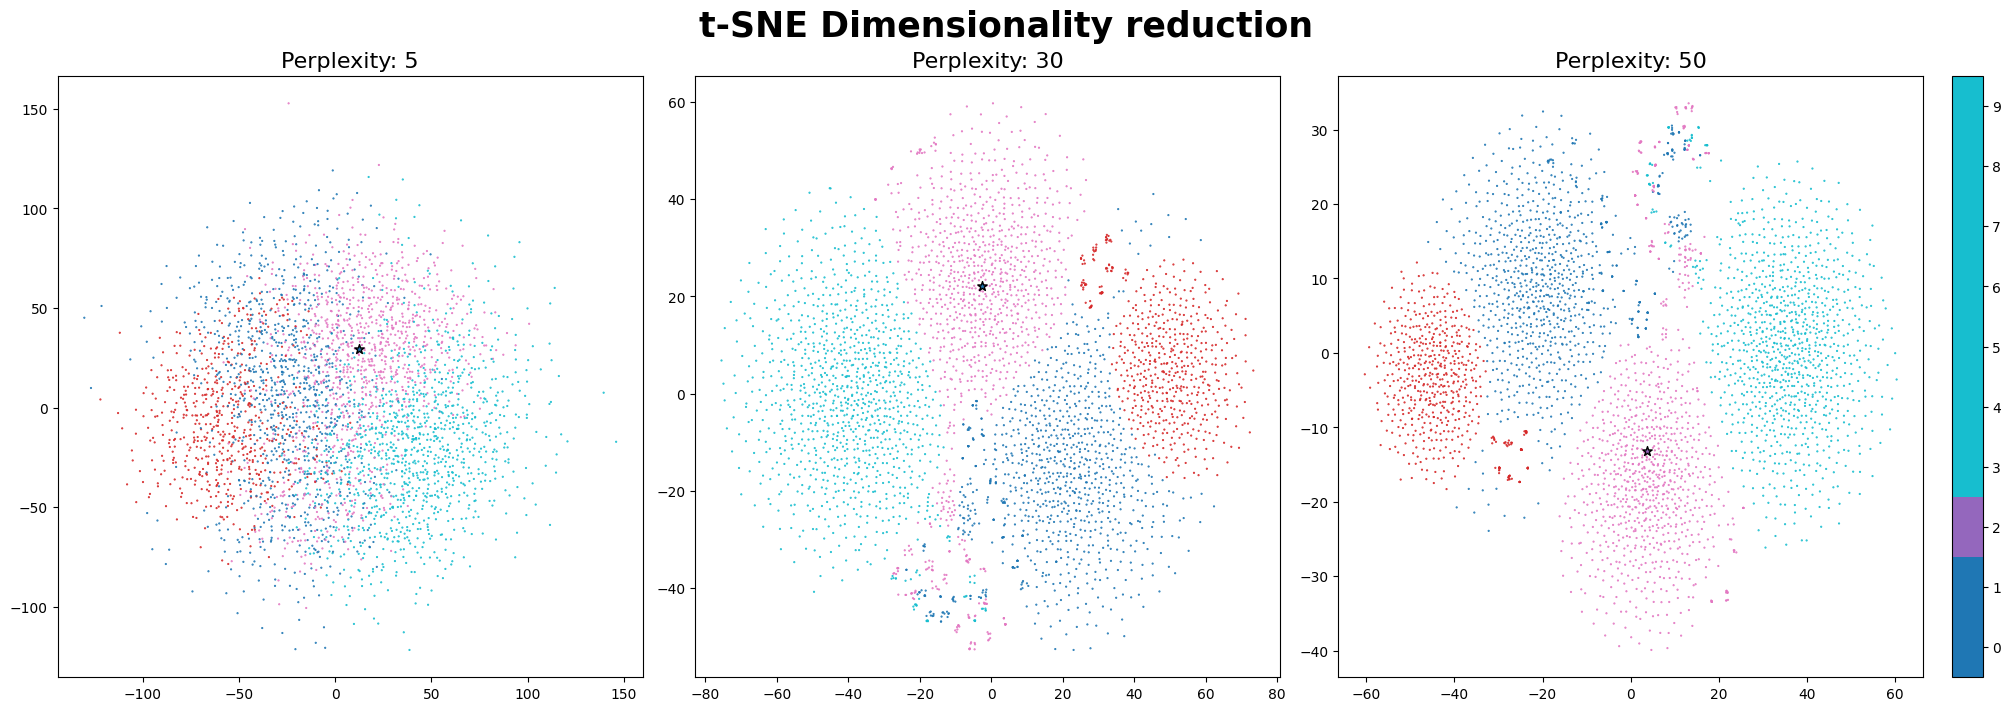

In [16]:
from sklearn.manifold import TSNE
import itertools
import cuml
# Function to extract features from the last fully connected layer before softmax
def extract_features(model, data_loader):
    features = []
    labels = []
    samples_to_run=5
    i=0
    with torch.no_grad():
        for data, target in data_loader:
            # Ensure data is converted to float and moved to the correct device
            data = data.float().to(model.device)  # Convert data to float here
            # Get the output from the last fully connected layer (fc1)
            x = model.conv1(data)
            x = model.relu1(x)
            x = model.maxpool1(x)
            x = model.conv2(x)
            x = model.relu2(x)
            x = model.maxpool2(x)
            x = torch.flatten(x, 1)
            x = model.fc1(x)
            x = model.relu3(x)
            # x= model.fc2(x)
            # x=model.logSoftmax(x)
            features.append(x.cpu().numpy())
            labels.append(target.numpy())
            if i > samples_to_run:
                break
            i+=1
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

features, labels = extract_features(model, dataloader)
print(features.shape,labels.shape)

fig, ax = plt.subplots(1, 3, figsize=(20,7), constrained_layout=True)
for c, per in zip(itertools.count(), [5, 30, 50]):
    tsne = cuml.manifold.TSNE(n_components=2,
                perplexity=per,
                n_neighbors=per*4)
    tsne = tsne.fit_transform(features)
    scatter = ax[c].scatter(tsne[:-1, 0], tsne[:-1, 1], c=labels[:-1], cmap='tab10', s=0.3)
    scatter = ax[c].scatter(tsne[-1, 0], tsne[-1, 1], c=labels[-1], cmap='tab10',marker='*', edgecolors='k', s=50)
    ax[c].set_title(f'Perplexity: {per}', fontsize=16)    

fig.suptitle('t-SNE Dimensionality reduction', fontweight='bold', fontsize=25)
cbar = fig.colorbar(scatter, boundaries=np.arange(11)-0.5, location='right')
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.show()